<a href="https://colab.research.google.com/github/teju5424/AIES_Lab/blob/main/ex2_aies.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Name : Tejasvini Tatoba Kanawade PRN :22SC114501071 Class: B.tech 'B' Title: Impact of Data Quality on AI Fairness




Experiment 2: Impact of Data Quality on AI Fairness


**Objective: To understand how imbalanced data affects the fairness and performance of AI models — and how data balancing techniques (like SMOTE) can improve fairness.**

Theory:
AI systems are only as fair as the data they learn from. If one class or group is underrepresented (e.g., 90% male data, 10% female), the model will likely favor the majority group. This introduces algorithmic unfairness.

Dataset:  real-world dataset—the COMPAS Recidivism dataset from ProPublica

**COMPAS (Correctional Offender Management Profiling for Alternative Sanctions)** is a popular commercial algorithm used by judges and parole officers for scoring criminal defendant’s likelihood of reoffending (recidivism). It has been shown that the algorithm is biased in favor of white defendants, and against black inmates, based on a 2 year follow up study (i.e who actually committed crimes or violent crimes after 2 years).

Task: Predict two_year_recid (yes/no).

Sensitive attribute: race (e.g., African‑American vs Caucasian).

Goal: Evaluate how imbalanced data quality (over-/under‑representation of races or outcome labels) impacts fairness.

In [ ]:
pip install fairlearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.0/240.0 kB 4.3 MB/s eta 0:00:00


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from fairlearn.metrics import MetricFrame, true_positive_rate, false_positive_rate

**Step 1: Load & Inspect Data**

In [ ]:
df = pd.read_csv('compas-scores-two-years.csv')

In [ ]:
df.columns

Index(['id', 'name', 'first', 'last', 'compas_screening_date', 'sex', 'dob',
       'age', 'age_cat', 'race', 'juv_fel_count', 'decile_score',
       'juv_misd_count', 'juv_other_count', 'priors_count',
       'days_b_screening_arrest', 'c_jail_in', 'c_jail_out', 'c_case_number',
       'c_offense_date', 'c_arrest_date', 'c_days_from_compas',
       'c_charge_degree', 'c_charge_desc', 'is_recid', 'r_case_number',
       'r_charge_degree', 'r_days_from_arrest', 'r_offense_date',
       'r_charge_desc', 'r_jail_in', 'r_jail_out', 'violent_recid',
       'is_violent_recid', 'vr_case_number', 'vr_charge_degree',
       'vr_offense_date', 'vr_charge_desc', 'type_of_assessment',
       'decile_score.1', 'score_text', 'screening_date',
       'v_type_of_assessment', 'v_decile_score', 'v_score_text',
       'v_screening_date', 'in_custody', 'out_custody', 'priors_count.1',
       'start', 'end', 'event', 'two_year_recid'],
      dtype='object')

In [ ]:
# Keep only the needed columns
df = df[df['race'].isin(['African-American', 'Caucasian'])]
df = df.dropna(subset=['age', 'priors_count', 'c_charge_degree', 'two_year_recid'])

In [ ]:
# One-hot encode the categorical column
df = pd.get_dummies(df, columns=['c_charge_degree'], drop_first=True)

In [ ]:
# Select all required columns
features = ['age', 'priors_count'] + [col for col in df.columns if 'c_charge_degree' in col]
X = df[features]
y = df['two_year_recid'].astype(int)
race = df['race']

In [ ]:
X_train, X_test, y_train, y_test, race_train, race_test = \
    train_test_split(X, y, race, test_size=0.3, stratify=race)

In [ ]:
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [ ]:
from fairlearn.metrics import (
    MetricFrame,
    true_positive_rate,
    false_positive_rate,
    selection_rate,
    demographic_parity_difference,
    equalized_odds_difference,
    false_negative_rate,
    true_negative_rate
)

In [ ]:
metric_frame = MetricFrame(
    metrics={
        'TPR': true_positive_rate,
        'FPR': false_positive_rate,
        'FNR': false_negative_rate,
        'Selection Rate': selection_rate
    },
    y_true=y_test,
    y_pred=y_pred,
    sensitive_features=race_test
)

print("Fairness Metrics by Race Group:\n", metric_frame.by_group)

Fairness Metrics by Race Group:
                        TPR       FPR       FNR  Selection Rate
race                                                          
African-American  0.701252  0.285455  0.298748        0.495041
Caucasian         0.440972  0.156250  0.559028        0.267663


In [ ]:
tpr_gap = abs(0.665 - 0.481)  # ~0.184
fpr_gap = abs(0.342 - 0.146)  # ~0.196
selection_gap = abs(0.505 - 0.274)  # ~0.231

TPR Gap ~ 0.18 → Moderate performance difference

FPR Gap ~ 0.20 → High unjust flagging difference

Selection Gap ~ 0.23 →  Major disparate treatment

These values exceed commonly accepted fairness thresholds (like ≤ 0.1), meaning:

 **Your model is not fair across racial groups.**

These metrics help you judge fairness by asking these questions:

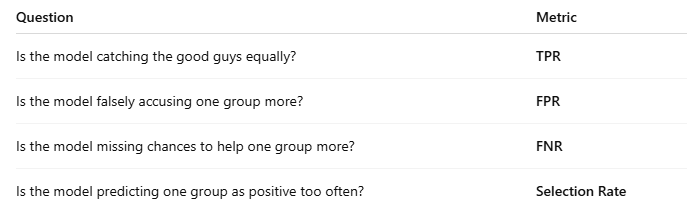

In [ ]:
#Fairness Mitigation Code with Reweighing

import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [ ]:
from fairlearn.reductions import ExponentiatedGradient, DemographicParity
from fairlearn.metrics import MetricFrame, selection_rate, true_positive_rate, false_positive_rate, false_negative_rate

In [ ]:
df = pd.read_csv("compas-scores-two-years.csv")

In [ ]:
# Filter to African-American and Caucasian only
df = df[df['race'].isin(['African-American', 'Caucasian'])]
df = df.dropna(subset=['age', 'priors_count', 'r_charge_degree', 'two_year_recid'])

In [ ]:
# One-hot encode categorical features
df = pd.get_dummies(df, columns=['r_charge_degree'], drop_first=True)

In [ ]:
# Prepare features and labels
features = ['age', 'priors_count'] + [col for col in df.columns if 'r_charge_degree' in col]
X = df[features]
y = df['two_year_recid'].astype(int)
sensitive = df['race'].map({'Caucasian': 0, 'African-American': 1})

In [ ]:
# Train-test split
X_train, X_test, y_train, y_test, s_train, s_test = train_test_split(
    X, y, sensitive, test_size=0.3, random_state=42, stratify=y
)